In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import datetime as dt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder,MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import string
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix , roc_curve, roc_auc_score
from sklearn.metrics import precision_score, recall_score, f1_score
import pickle

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, SpatialDropout1D
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer,one_hot

import tensorflow as tf
from tensorflow.keras import regularizers

from tensorflow.keras import layers
from tensorflow.keras import losses

from collections import Counter

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/train_en.tsv', sep='\t')

In [ ]:
data.head()

,id,text,HS,TR,AG
0,201,"Hurray, saving us $$$ in so many ways @potus @...",1,0,0
1,202,Why would young fighting age men be the vast m...,1,0,0
2,203,@KamalaHarris Illegals Dump their Kids at the ...,1,0,0
3,204,NY Times: 'Nearly All White' States Pose 'an A...,0,0,0
4,205,Orban in Brussels: European leaders are ignori...,0,0,0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      9000 non-null   int64 
 1   text    9000 non-null   object
 2   HS      9000 non-null   int64 
 3   TR      9000 non-null   int64 
 4   AG      9000 non-null   object
dtypes: int64(3), object(2)
memory usage: 351.7+ KB


In [ ]:
data['AG']

0       0
1       0
2       0
3       0
4       0
       ..
8995    0
8996    0
8997    1
8998    0
8999    0
Name: AG, Length: 9000, dtype: object

In [ ]:
def find_non_numeric(column):
    non_numeric_values = column[~column.apply(lambda x: str(x).isdigit())]
    return non_numeric_values


In [ ]:
non_numeric_AG = find_non_numeric(data['AG'])

In [ ]:
non_numeric_AG = find_non_numeric(data['AG'])

In [ ]:
data = data[data['AG'].apply(lambda x: str(x).isdigit())]

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8985 entries, 0 to 8999
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        8985 non-null   int64 
 1   text      8985 non-null   object
 2   HS        8985 non-null   int64 
 3   TR        8985 non-null   int64 
 4   AG        8985 non-null   int64 
 5   text_len  8985 non-null   int64 
dtypes: int64(5), object(1)
memory usage: 491.4+ KB


In [ ]:
data['AG'] = data['AG'].astype(int)

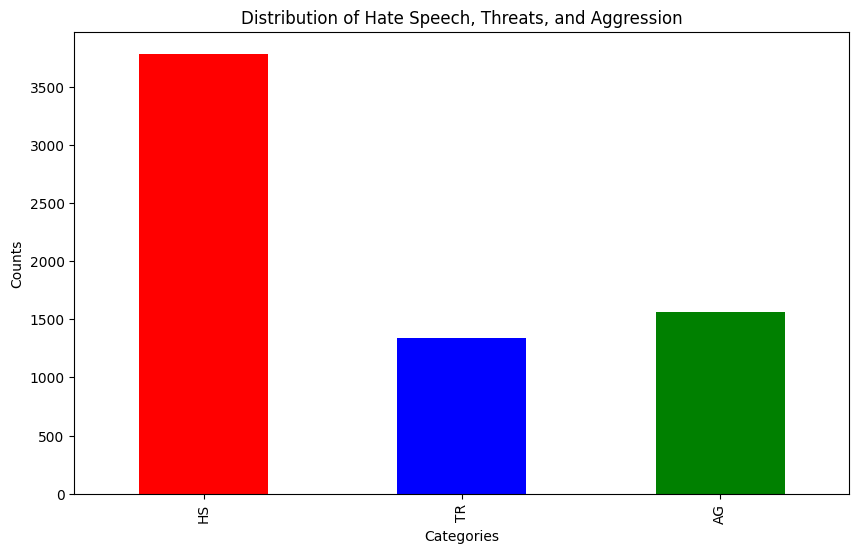

In [ ]:
plt.figure(figsize=(10, 6))
data[['HS', 'TR', 'AG']].sum().plot(kind='bar', color=['red', 'blue', 'green'])
plt.title('Distribution of Hate Speech, Threats, and Aggression')
plt.xlabel('Categories')
plt.ylabel('Counts')
plt.show()

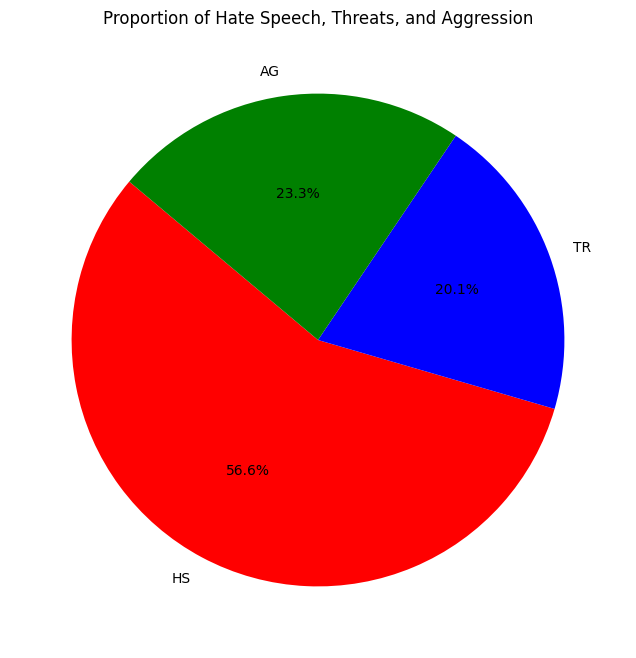

In [ ]:
plt.figure(figsize=(8, 8))
data[['HS', 'TR', 'AG']].sum().plot(kind='pie', autopct='%1.1f%%', startangle=140, colors=['red', 'blue', 'green'])
plt.title('Proportion of Hate Speech, Threats, and Aggression')
plt.ylabel('')
plt.show()


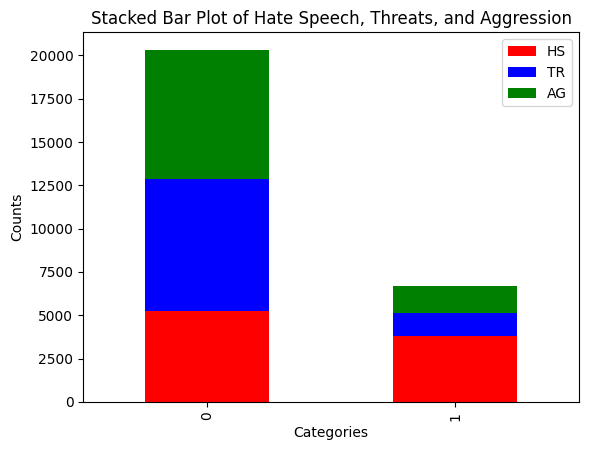

In [ ]:
counts = data[['HS', 'TR', 'AG']].apply(pd.Series.value_counts).fillna(0).astype(int)
counts.plot(kind='bar', stacked=True, color=['red', 'blue', 'green'])
plt.title('Stacked Bar Plot of Hate Speech, Threats, and Aggression')
plt.xlabel('Categories')
plt.ylabel('Counts')
plt.show()

In [ ]:
def preprocess_text(text):
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    # Remove special characters, numbers, and punctuations (except for hashtags and @mentions)
    text = re.sub("[^a-zA-Z#@]", " ", text)
    # Convert to lowercase
    text = text.lower()
    # Tokenize text
    words = word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    exclude =string.punctuation
    words = [word for word in words if word not in exclude]

    # Lemmatize words based on POS tags
    lemmatizer = WordNetLemmatizer()
    tagged_words = pos_tag(words)
    lemmatized_words = []
    for word, tag in tagged_words:
        if tag.startswith('NN'):  # Noun
            pos = 'n'
        elif tag.startswith('VB'):  # Verb
            pos = 'v'
        elif tag.startswith('JJ'):  # Adjective
            pos = 'a'
        else:
            pos = 'n'  # Default to noun
        lemmatized_words.append(lemmatizer.lemmatize(word, pos))
    text = ' '.join(lemmatized_words)
    return text



In [ ]:
data['text'] = data['text'].apply(preprocess_text)

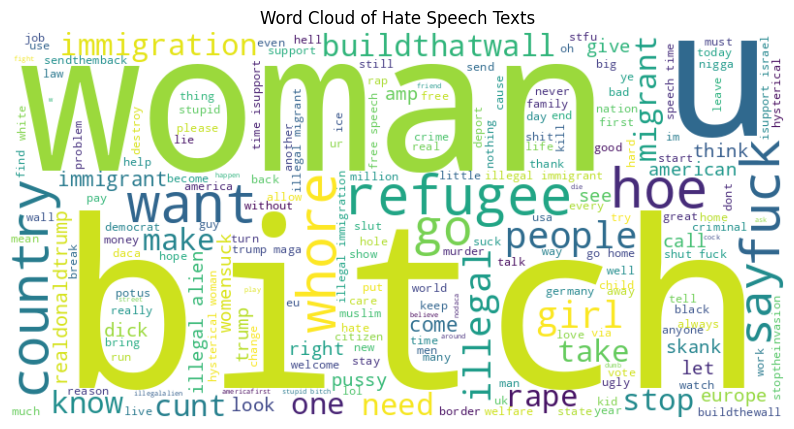

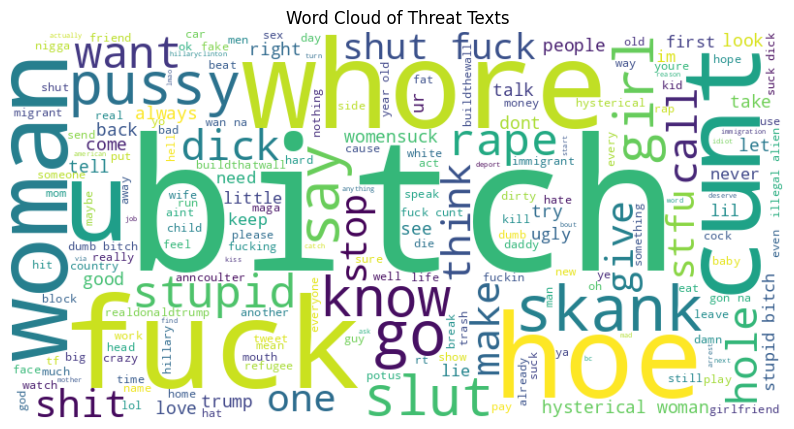

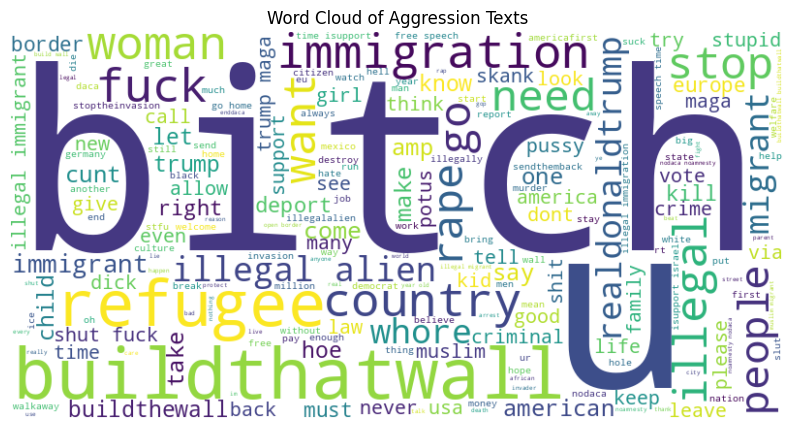

In [ ]:
hs_text = ' '.join(text for text in data[data['HS'] == 1].text)
wordcloud_hs = WordCloud(width=800, height=400, background_color='white').generate(hs_text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_hs, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Hate Speech Texts')
plt.show()

#Word Cloud: Most common words in tweets containing Threats
tr_text = ' '.join(text for text in data[data['TR'] == 1].text)
wordcloud_tr = WordCloud(width=800, height=400, background_color='white').generate(tr_text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_tr, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Threat Texts')
plt.show()

#  Word Cloud: Most common words in tweets containing Aggression
ag_text = ' '.join(text for text in data[data['AG'] == 1].text)
wordcloud_ag = WordCloud(width=800, height=400, background_color='white').generate(ag_text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_ag, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Aggression Texts')
plt.show()


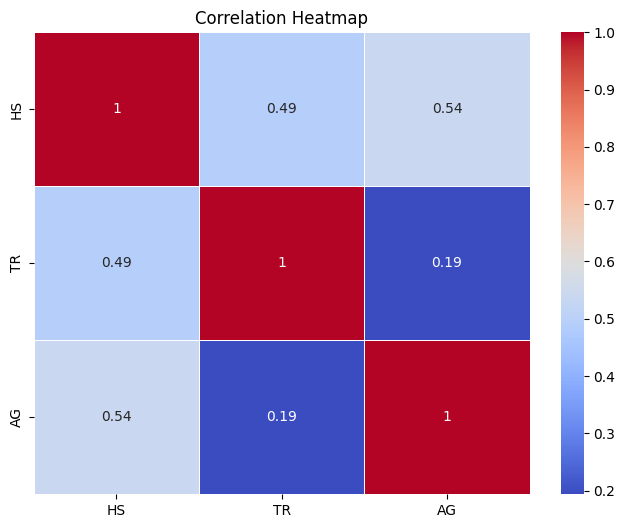

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(data[['HS', 'TR', 'AG']].corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

In [ ]:
data['text_len'] = [len(t.split()) for t in data.text]

In [ ]:
data.sort_values(by=['text_len'], ascending=False)

,id,text,HS,TR,AG,text_len
1868,2069,white dragon society amp russia amp com amp gn...,0,0,0,43
3728,3929,ramnrambo vox e con la dictadura periodistica ...,0,0,0,42
4040,4241,fascist whose day do jason kessler richard spe...,0,0,0,41
8570,8771,cheap woman expensive woman black woman white ...,0,0,0,40
8546,8747,first go bitch as janelle fuck messy mf as bit...,1,1,1,39
...,...,...,...,...,...,...
1321,1522,,0,0,0,0
1649,1850,,0,0,0,0
7175,7376,,0,0,0,0
1018,1219,,0,0,0,0


In [ ]:
len(data[data['text_len']==0])

14

In [ ]:
data = data[data['text_len'] > 0]

<ipython-input-28-a52a1700b42f>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='text_len', data=data[data['text_len']<=1000], palette='Blues_r')


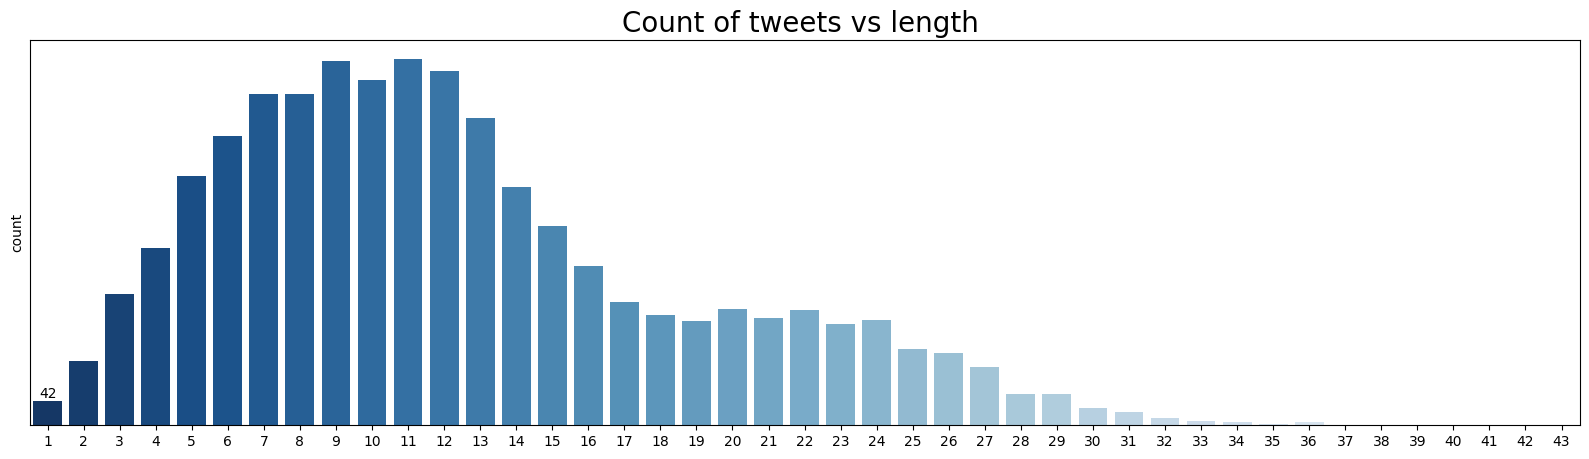

In [ ]:
plt.figure(figsize=(20,5))
ax = sns.countplot(x='text_len', data=data[data['text_len']<=1000], palette='Blues_r')
plt.title('Count of tweets vs length ', fontsize=20)
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

In [ ]:
data.head()

,id,text,HS,TR,AG,text_len
0,201,hurray save u many way potus realdonaldtrump l...,1,0,0,12
1,202,would young fight age men vast majority one es...,1,0,0,25
2,203,kamalaharris illegals dump kid border like roa...,1,0,0,25
3,204,ny time nearly white state pose array problem ...,0,0,0,9
4,205,orban brussels european leader ignore people w...,0,0,0,8


In [ ]:
data['HS'].value_counts()

HS
0    5203
1    3782
Name: count, dtype: int64

# **TASK A**

In [ ]:
X_train = data['text']
y_train = data['HS']

In [ ]:
X_tr, X_test, y_tr, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [ ]:
tfidf_vectorizer = TfidfVectorizer()

In [ ]:
X_tfidf = tfidf_vectorizer.fit_transform(X_tr)

In [ ]:
X_test_tf = tfidf_vectorizer.transform(X_test)

In [ ]:
# smote = SMOTE(random_state=42)
# X_train_resampled, y_train_resampled = smote.fit_resample(X_tfidf, y_tr)

In [ ]:
X_train.shape

(8985,)

In [ ]:
def evaluate_model(model, X_test, y_test, model_name, evaluation_dict):
    # Generate predictions
    y_pred = model.predict(X_test)

    # Classification report
    report = classification_report(y_test, y_pred, output_dict=True)

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # ROC curve
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:, 1]
    else:  # use decision function
        y_prob = model.decision_function(X_test)

    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = roc_auc_score(y_test, y_prob)

    # Store evaluation metrics in the dictionary
    evaluation_dict[model_name] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'roc_auc': roc_auc,
        'classification_report': report,
        'confusion_matrix': cm
    }

    # Print classification report
    print("Classification Report for", model_name)
    print(classification_report(y_test, y_pred))

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix for ' + model_name)
    plt.show()

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for ' + model_name)
    plt.legend(loc="lower right")
    plt.show()


In [ ]:
evaluation_dict = {}

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Classification Report for Logistic Regression
              precision    recall  f1-score   support

           0       0.78      0.87      0.82      1055
           1       0.78      0.65      0.71       742

    accuracy                           0.78      1797
   macro avg       0.78      0.76      0.76      1797
weighted avg       0.78      0.78      0.77      1797



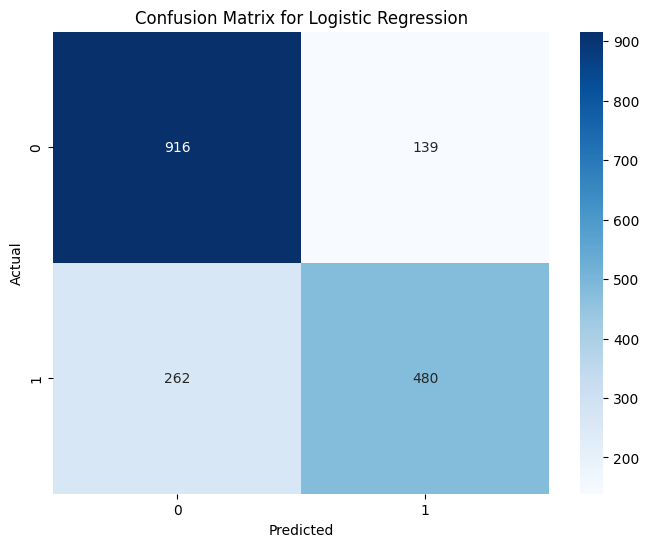

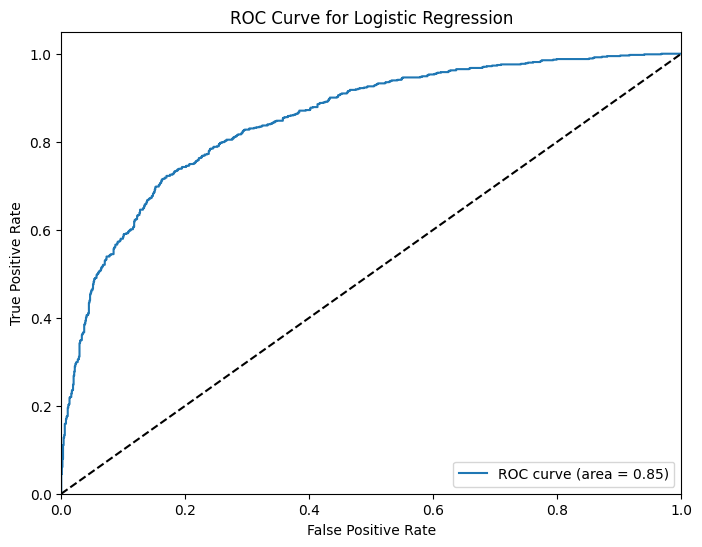

Best Parameters: {'C': 1}
Best Score: 0.7636334776418574


In [ ]:
logistic = LogisticRegression(random_state=42)

# Define hyperparameters to tune
parameters = {
    'C': [0.1, 1, 10],
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(logistic, param_grid=parameters, cv=5, n_jobs=-1)
grid_search.fit(X_tfidf , y_tr)

# Evaluate the model
evaluate_model(grid_search.best_estimator_, X_test_tf, y_test,'Logistic Regression', evaluation_dict)

# Print the best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)


Classification Report for SVM
              precision    recall  f1-score   support

           0       0.78      0.87      0.82      1055
           1       0.78      0.65      0.71       742

    accuracy                           0.78      1797
   macro avg       0.78      0.76      0.77      1797
weighted avg       0.78      0.78      0.78      1797



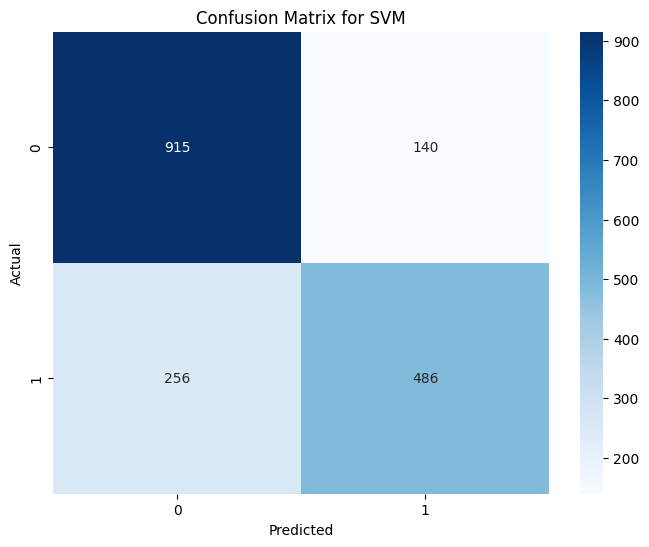

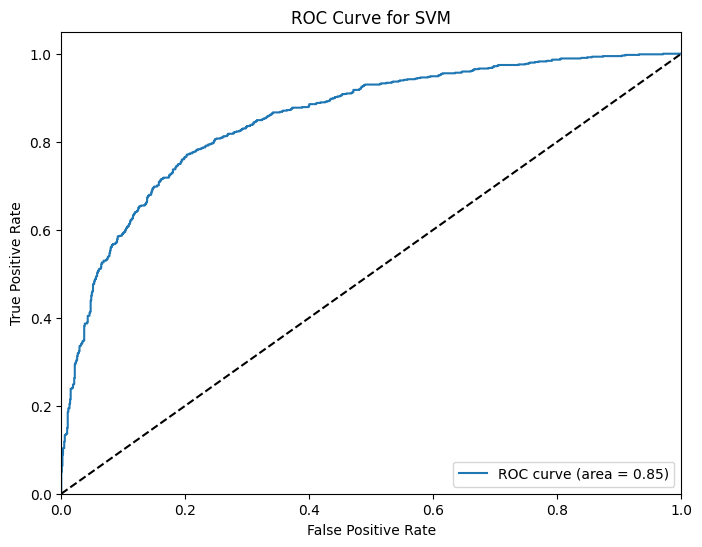

In [ ]:
svm = SVC(random_state=42)

# Train the model
svm.fit(X_tfidf , y_tr)


evaluate_model(svm,X_test_tf, y_test, 'SVM', evaluation_dict)

Best Parameters: {'alpha': 0.5}
Best Score: 0.7345573909483422
Classification Report for Naive Bayes
              precision    recall  f1-score   support

           0       0.76      0.83      0.79      1055
           1       0.72      0.62      0.67       742

    accuracy                           0.75      1797
   macro avg       0.74      0.73      0.73      1797
weighted avg       0.74      0.75      0.74      1797



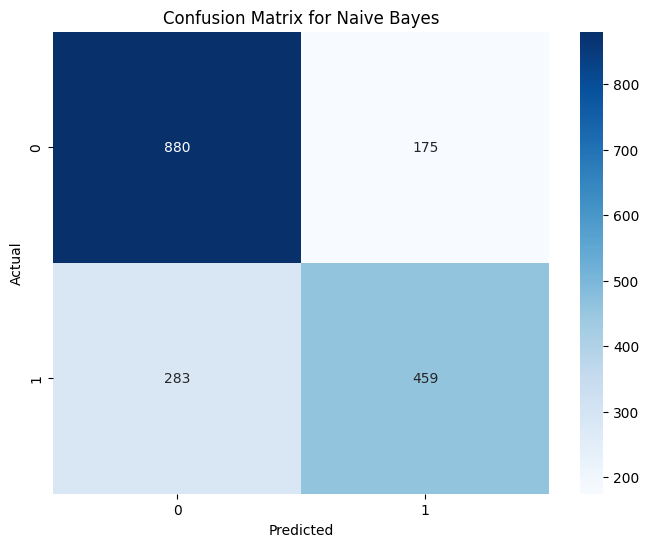

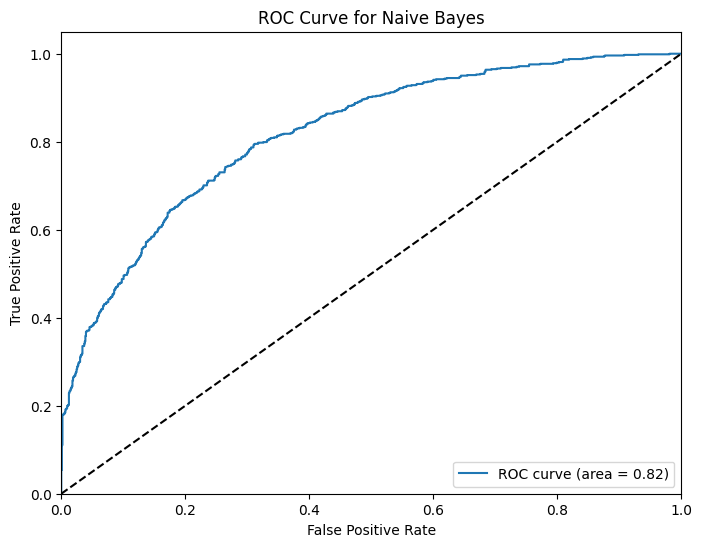

In [ ]:
naive_bayes = MultinomialNB()

# Define hyperparameters to tune
parameters = {
    'alpha': [0.1, 0.5, 1.0],
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(naive_bayes, param_grid=parameters, cv=5, n_jobs=-1)
grid_search.fit(X_tfidf , y_tr)

# Print the best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)
best_model = grid_search.best_estimator_
# Save the best model


# Evaluate the best model
evaluate_model(best_model, X_test_tf, y_test, 'Naive Bayes', evaluation_dict)

Classification Report for Random Forest
              precision    recall  f1-score   support

           0       0.80      0.86      0.83      1055
           1       0.78      0.69      0.73       742

    accuracy                           0.79      1797
   macro avg       0.79      0.78      0.78      1797
weighted avg       0.79      0.79      0.79      1797



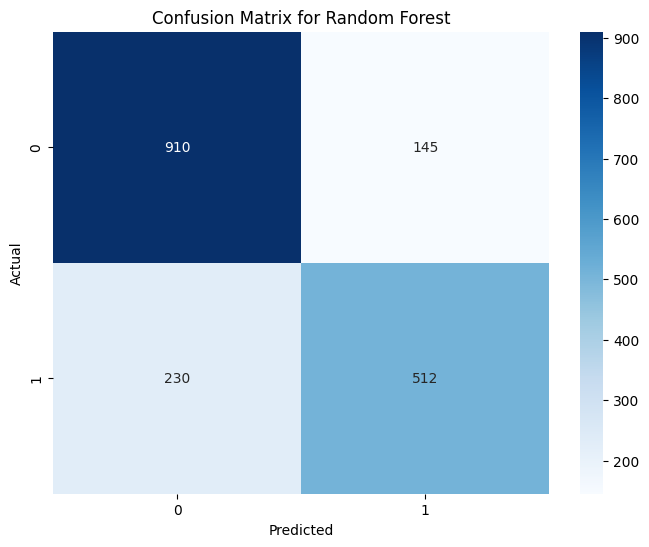

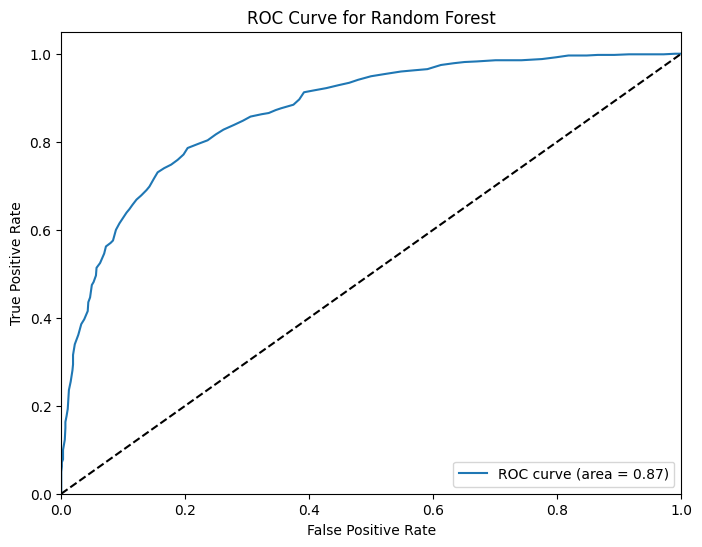

In [ ]:
random_forest = RandomForestClassifier(random_state=42)


random_forest.fit(X_tfidf , y_tr)
# Evaluate the best model
evaluate_model(random_forest, X_test_tf, y_test, 'Random Forest', evaluation_dict)

# **TASK - B**

**PART-1**

In [ ]:
data['TR'].value_counts()

TR
0    7644
1    1341
Name: count, dtype: int64

In [ ]:
X_train1 = data['text']
y_train1 = data['TR']

In [ ]:
X_tr1, X_test1, y_tr1, y_test1 = train_test_split(X_train1, y_train1, test_size=0.2, random_state=42)

In [ ]:
tfidf_vectorizer1 = TfidfVectorizer()

In [ ]:
X_tfidf1= tfidf_vectorizer1.fit_transform(X_tr1)

In [ ]:
X_test_tf1 = tfidf_vectorizer1.transform(X_test1)

In [ ]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_tfidf1, y_tr1)

In [ ]:
evaluation_dict1={}

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Classification Report for Logistic Regression
              precision    recall  f1-score   support

           0       0.94      0.91      0.93      1528
           1       0.57      0.70      0.63       269

    accuracy                           0.88      1797
   macro avg       0.76      0.80      0.78      1797
weighted avg       0.89      0.88      0.88      1797



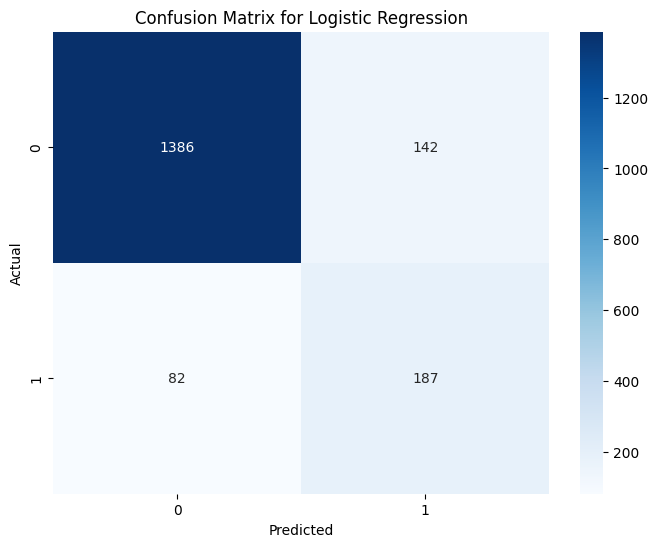

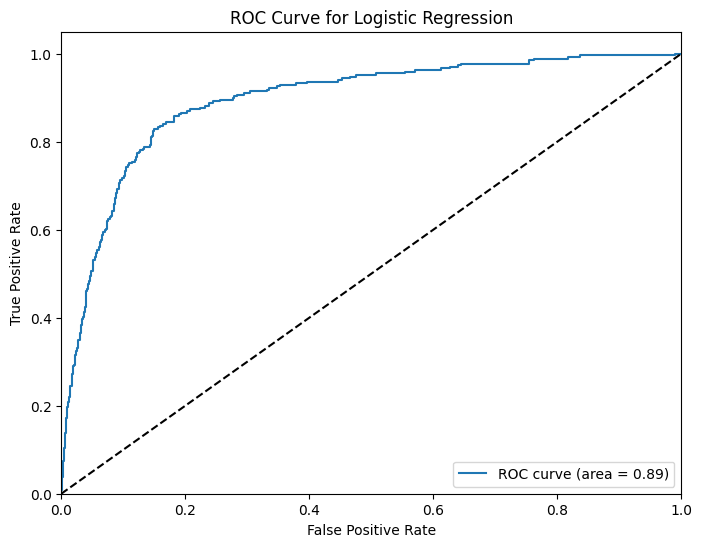

Best Parameters: {'C': 10}
Best Score: 0.9528291856031432


In [ ]:
logistic = LogisticRegression(random_state=42)

# Define hyperparameters to tune
parameters = {
    'C': [0.1, 1, 10],
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(logistic, param_grid=parameters, cv=5, n_jobs=-1)
grid_search.fit(X_train_resampled, y_train_resampled)

# Evaluate the model
evaluate_model(grid_search.best_estimator_, X_test_tf1, y_test1,'Logistic Regression', evaluation_dict1)

# Print the best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)



Classification Report for SVM
              precision    recall  f1-score   support

           0       0.91      0.96      0.94      1528
           1       0.67      0.49      0.57       269

    accuracy                           0.89      1797
   macro avg       0.79      0.73      0.75      1797
weighted avg       0.88      0.89      0.88      1797



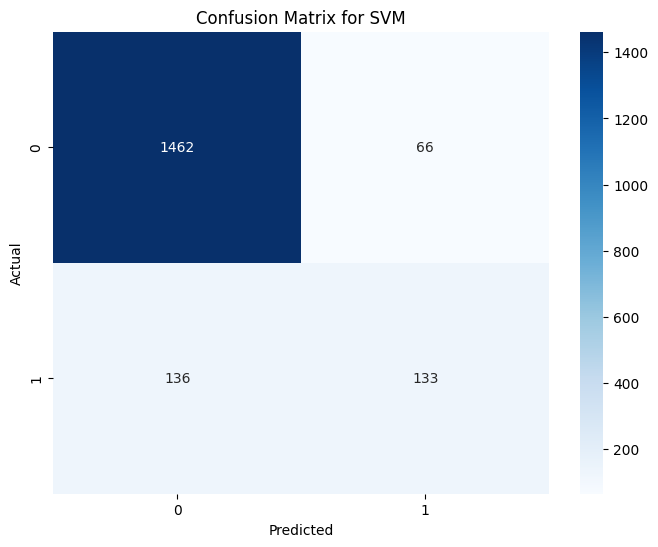

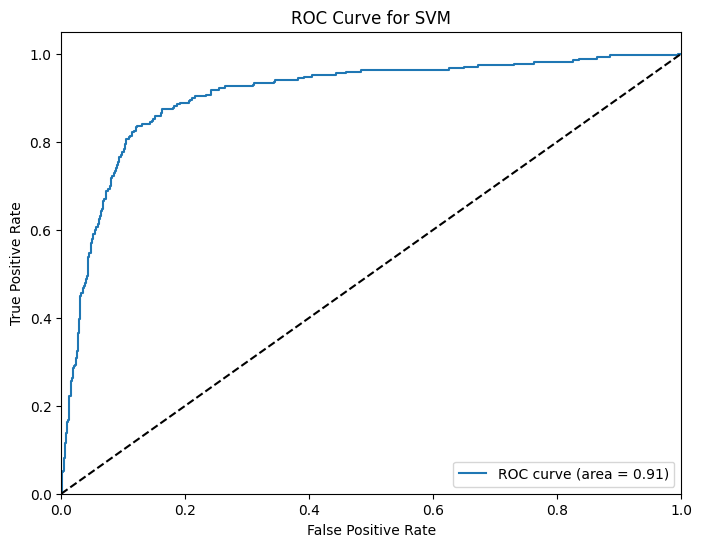

In [ ]:
svm = SVC(random_state=42)

# Train the model
svm.fit(X_train_resampled, y_train_resampled)


# Evaluate the model
evaluate_model(svm,X_test_tf1, y_test1, 'SVM', evaluation_dict1)

Best Parameters: {'alpha': 0.1}
Best Score: 0.8988720815883816
Classification Report for Naive Bayes
              precision    recall  f1-score   support

           0       0.93      0.83      0.88      1528
           1       0.40      0.67      0.50       269

    accuracy                           0.80      1797
   macro avg       0.67      0.75      0.69      1797
weighted avg       0.85      0.80      0.82      1797



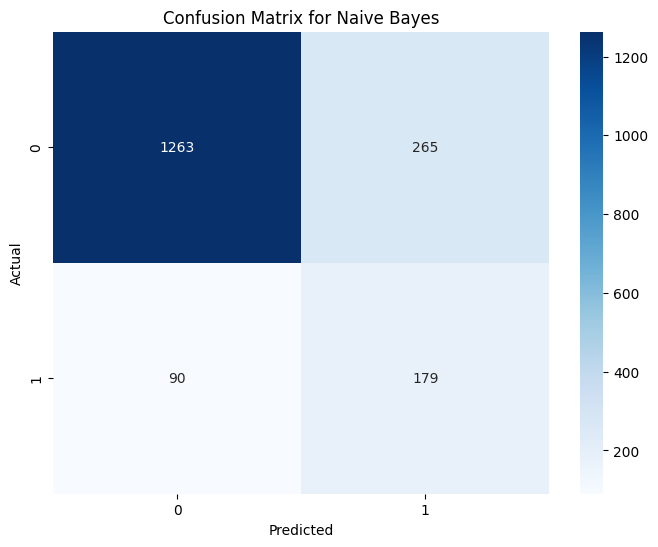

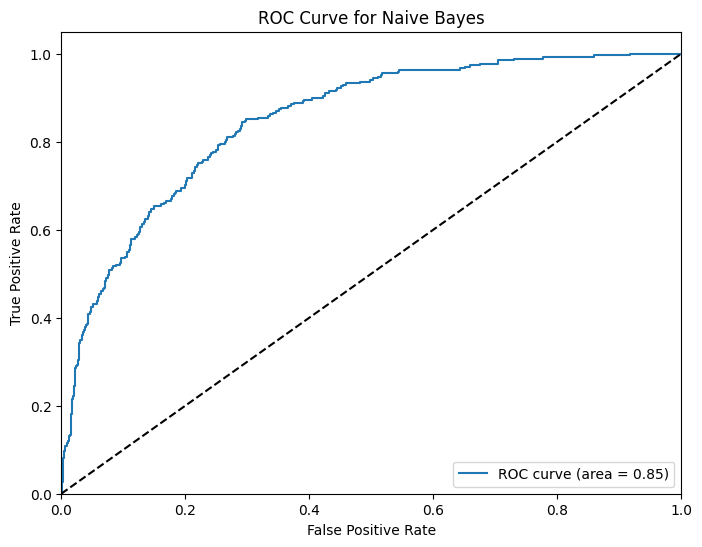

In [ ]:
naive_bayes = MultinomialNB()

# Define hyperparameters to tune
parameters = {
    'alpha': [0.1, 0.5, 1.0],
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(naive_bayes, param_grid=parameters, cv=5, n_jobs=-1)
grid_search.fit(X_train_resampled, y_train_resampled)

# Print the best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)
best_model = grid_search.best_estimator_


# Evaluate the best model
evaluate_model(best_model, X_test_tf1, y_test1, 'Naive Bayes', evaluation_dict1)

Classification Report for Random Forest
              precision    recall  f1-score   support

           0       0.94      0.94      0.94      1528
           1       0.64      0.65      0.65       269

    accuracy                           0.89      1797
   macro avg       0.79      0.79      0.79      1797
weighted avg       0.89      0.89      0.89      1797



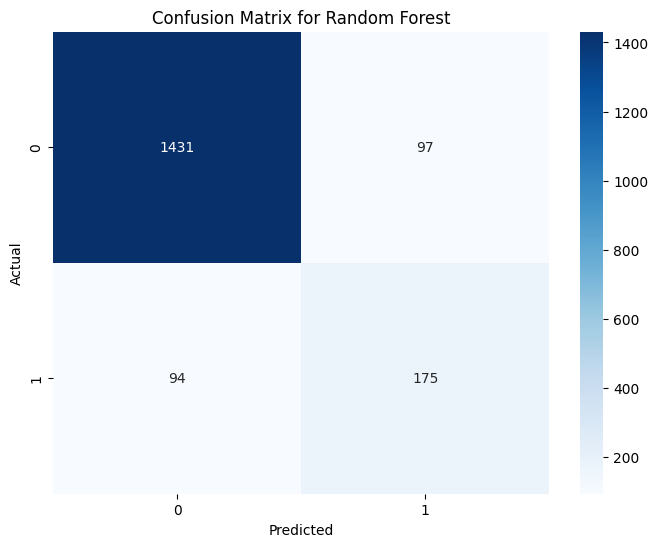

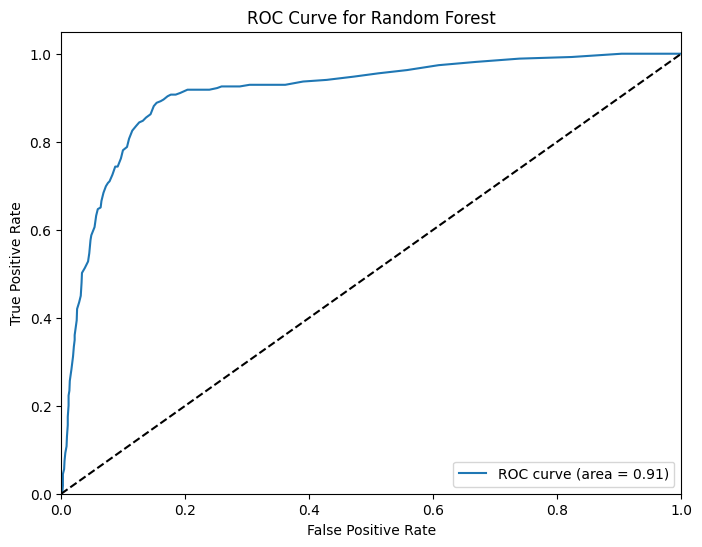

In [ ]:
random_forest = RandomForestClassifier(random_state=42)


random_forest.fit(X_train_resampled, y_train_resampled)

# Evaluate the best model
evaluate_model(random_forest, X_test_tf1, y_test1, 'Random Forest', evaluation_dict1)

**PART-2**

In [ ]:
data['AG'].value_counts()

AG
0    7426
1    1559
Name: count, dtype: int64

In [ ]:
X_train2= data['text']
y_train2 = data['AG']

In [ ]:
X_tr2, X_test2, y_tr2, y_test2 = train_test_split(X_train2, y_train2, test_size=0.2, random_state=42)

In [ ]:
tfidf_vectorizer2 = TfidfVectorizer()

In [ ]:
X_tfidf2 = tfidf_vectorizer2.fit_transform(X_tr2)

In [ ]:
X_test_tf2 = tfidf_vectorizer2.transform(X_test2)

In [ ]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_tfidf2 , y_tr2)

In [ ]:
evaluation_dict3={}

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Classification Report for Logistic Regression
              precision    recall  f1-score   support

           0       0.90      0.88      0.89      1485
           1       0.47      0.52      0.50       312

    accuracy                           0.82      1797
   macro avg       0.69      0.70      0.69      1797
weighted avg       0.82      0.82      0.82      1797



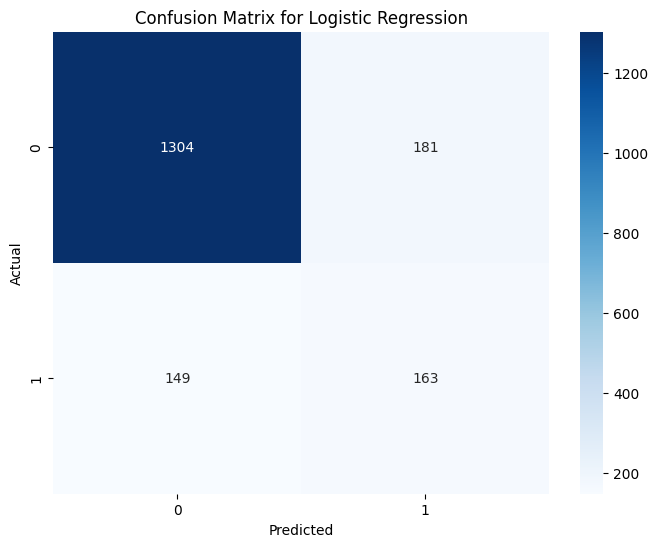

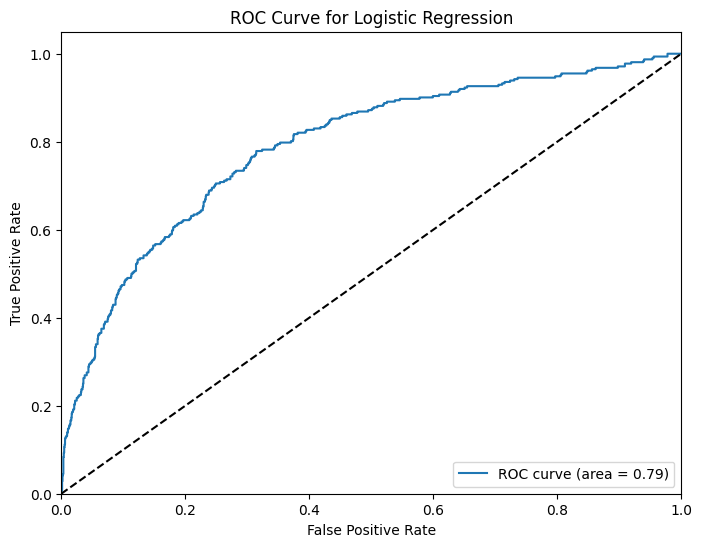

Best Parameters: {'C': 10}
Best Score: 0.9337671342509374


In [ ]:
logistic = LogisticRegression(random_state=42)

# Define hyperparameters to tune
parameters = {
    'C': [0.1, 1, 10],
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(logistic, param_grid=parameters, cv=5, n_jobs=-1)
grid_search.fit(X_train_resampled, y_train_resampled)

# Evaluate the model
evaluate_model(grid_search.best_estimator_, X_test_tf2, y_test2,'Logistic Regression', evaluation_dict3)

# Print the best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)




Classification Report for SVM
              precision    recall  f1-score   support

           0       0.86      0.98      0.91      1485
           1       0.68      0.24      0.36       312

    accuracy                           0.85      1797
   macro avg       0.77      0.61      0.64      1797
weighted avg       0.83      0.85      0.82      1797



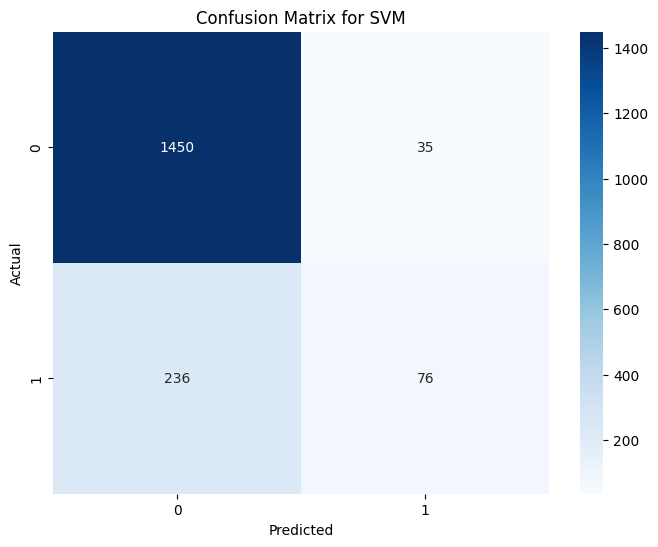

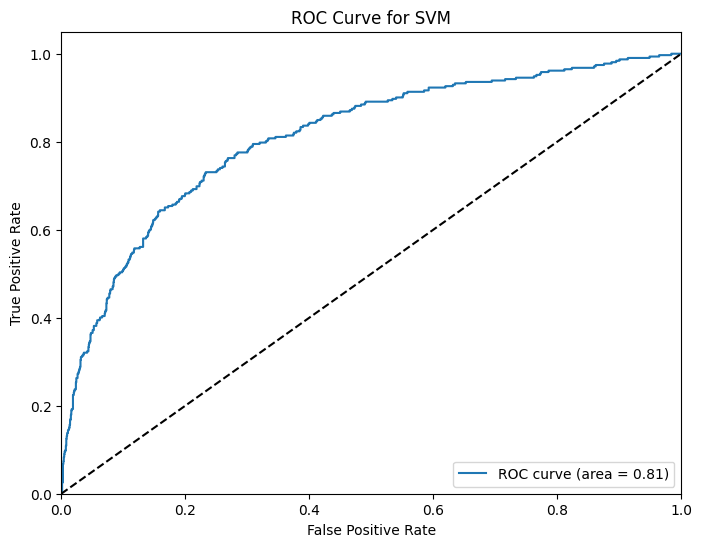

In [ ]:
svm = SVC(random_state=42)

# Train the model
svm.fit(X_train_resampled, y_train_resampled)

# Evaluate the model
evaluate_model(svm,X_test_tf2, y_test2, 'SVM', evaluation_dict3)

Best Parameters: {'alpha': 0.1}
Best Score: 0.8900866751939533
Classification Report for Naive Bayes
              precision    recall  f1-score   support

           0       0.89      0.82      0.85      1485
           1       0.38      0.53      0.44       312

    accuracy                           0.77      1797
   macro avg       0.64      0.68      0.65      1797
weighted avg       0.80      0.77      0.78      1797



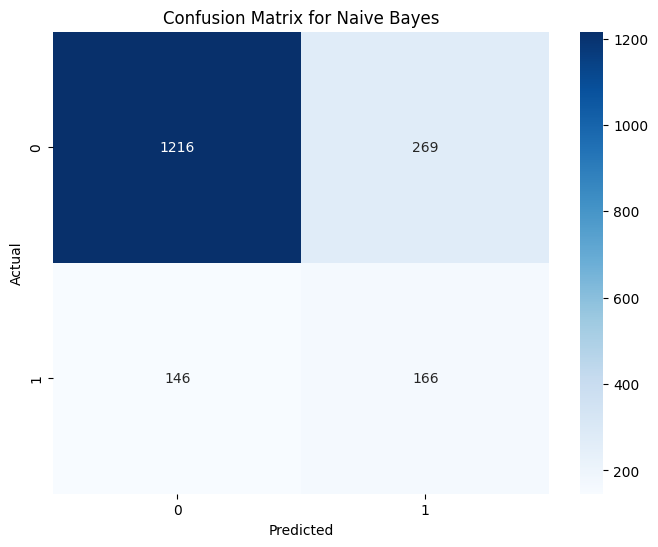

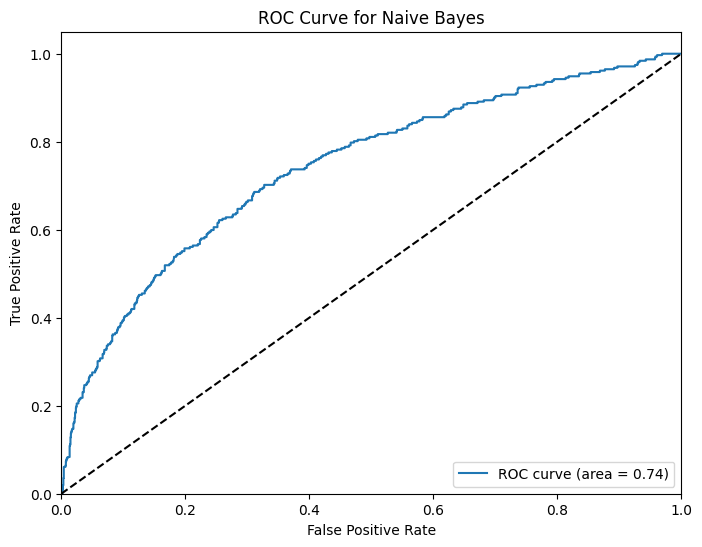

In [ ]:
naive_bayes = MultinomialNB()

# Define hyperparameters to tune
parameters = {
    'alpha': [0.1, 0.5, 1.0],
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(naive_bayes, param_grid=parameters, cv=5, n_jobs=-1)
grid_search.fit(X_train_resampled, y_train_resampled)

# Print the best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)
best_model = grid_search.best_estimator_

# Evaluate the best model
evaluate_model(best_model, X_test_tf2, y_test2, 'Naive Bayes', evaluation_dict3)

Classification Report for Random Forest
              precision    recall  f1-score   support

           0       0.87      0.96      0.92      1485
           1       0.66      0.33      0.44       312

    accuracy                           0.85      1797
   macro avg       0.77      0.65      0.68      1797
weighted avg       0.84      0.85      0.83      1797



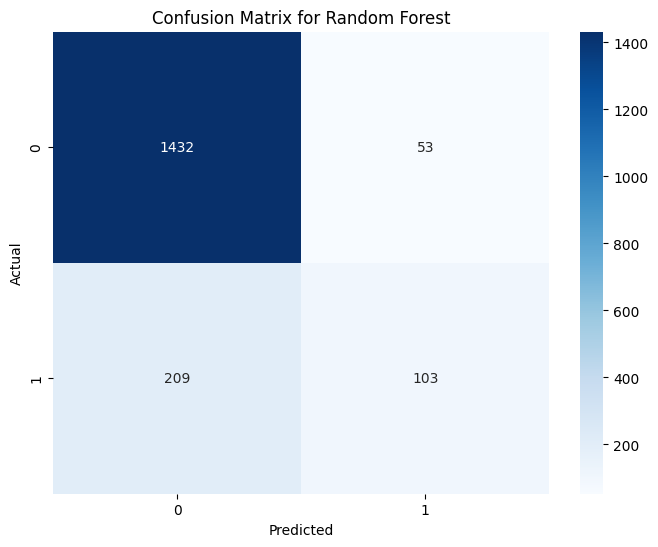

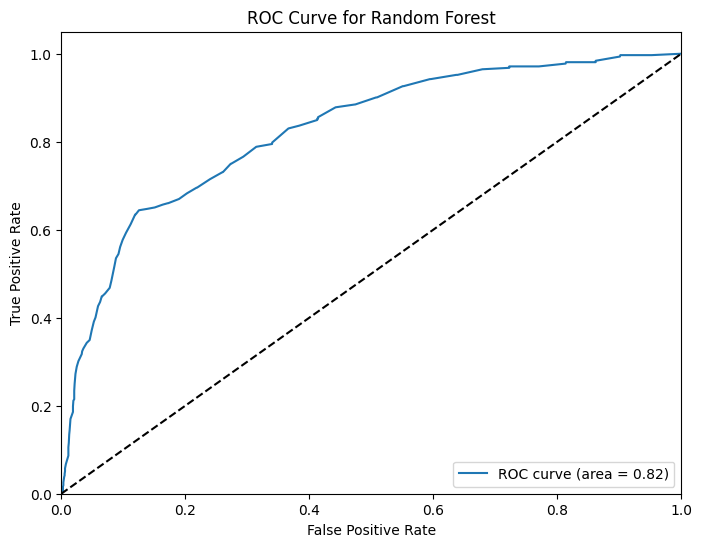

In [ ]:
random_forest = RandomForestClassifier(random_state=42)


random_forest.fit(X_train_resampled, y_train_resampled)
evaluate_model(random_forest, X_test_tf2, y_test2, 'Random Forest', evaluation_dict3)